In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("data/Taxicab_Trips_Sampling_in_July_2017.csv")

In [3]:
df = df.loc[df.TOTALAMOUNT>0]
df = df.loc[df.TOTALAMOUNT<1000]
df = df.loc[df.METERFARE>0]
df = df.loc[df.TRIPMILEAGE>0]
df = df.loc[df.TRIPMILEAGE<200]
df = df.loc[df.TRIPTIME>0]
df = df.loc[df.TRIPTIME<120]
df.AIRPORT = df.AIRPORT == "Y"
df["pickup_quadrant"] = df.PICKUP_BLOCKNAME.str.extract(r"\s([NS][EW])\b")
df["dropoff_quadrant"] = df.DROPOFF_BLOCKNAME.str.extract(r"\s([NS][EW])\b")
df["tipping"] = (df.TIP>0) * 1 

df['pickup_datetime'] = pd.to_datetime(df.PICKUPDATETIME_TR)
df['dropoff_datetime'] = pd.to_datetime(df.DROPOFFDATETIME_TR)
df['pickup_date'] = df.pickup_datetime.dt.date
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['dropoff_date'] = df.dropoff_datetime.dt.date
df['dropoff_hour'] = df.dropoff_datetime.dt.hour

df = df.drop(["OBJECTID_1", "OBJECTID"], axis=1)

In [4]:
df.loc[df.DROPOFFSTATE=="Virgin Islands", "DROPOFFSTATE"] = "Virginia"
df.loc[df.PICKUPSTATE=="Virgin Islands", "PICKUPSTATE"] = "Virginia"
df.loc[df.DROPOFFSTATE=="Washington", "DROPOFFSTATE"] = "District of Columbia"
df.loc[df.PICKUPSTATE=="Washington", "PICKUPSTATE"] = "District of Columbia"
df.loc[df.PAYMENTCARDPROVIDER=="Unknown = 0", "PAYMENTCARDPROVIDER"] = np.nan

In [5]:
df.head()

,TRIPTYPE,PROVIDER,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,PAYMENTTYPE,PAYMENTCARDPROVIDER,...,DROPOFFDATETIME_TR,pickup_quadrant,dropoff_quadrant,tipping,pickup_datetime,dropoff_datetime,pickup_date,pickup_hour,dropoff_date,dropoff_hour
0,PSP,"Transco, Inc.",3.52,0.00,0.25,21.75,0.0,25.52,CreditCard,VisaCredit,...,2017-07-28T18:00:00.000Z,NE,NE,0,2017-07-28 18:00:00+00:00,2017-07-28 18:00:00+00:00,2017-07-28,18,2017-07-28,18
1,PSP,"Transco, Inc.",5.14,0.00,0.25,0.00,0.0,5.39,Cash,Cash,...,2017-07-28T18:00:00.000Z,NE,NE,0,2017-07-28 18:00:00+00:00,2017-07-28 18:00:00+00:00,2017-07-28,18,2017-07-28,18
2,PSP,"Transco, Inc.",14.32,4.67,0.25,1.00,0.0,20.24,CreditCard,MasterCardCredit,...,2017-07-28T19:00:00.000Z,SW,NW,1,2017-07-28 19:00:00+00:00,2017-07-28 19:00:00+00:00,2017-07-28,19,2017-07-28,19
3,PSP,"Transco, Inc.",4.33,1.12,0.25,1.00,0.0,6.70,CreditCard,MasterCardCredit,...,2017-07-28T19:00:00.000Z,NW,NW,1,2017-07-28 19:00:00+00:00,2017-07-28 19:00:00+00:00,2017-07-28,19,2017-07-28,19
4,PSP,"Transco, Inc.",11.89,0.00,0.25,1.00,0.0,13.14,Cash,Cash,...,2017-07-29T15:00:00.000Z,NW,NW,0,2017-07-29 14:00:00+00:00,2017-07-29 15:00:00+00:00,2017-07-29,14,2017-07-29,15


In [6]:
df.columns

Index(['TRIPTYPE', 'PROVIDER', 'METERFARE', 'TIP', 'SURCHARGE', 'EXTRAS',
       'TOLLS', 'TOTALAMOUNT', 'PAYMENTTYPE', 'PAYMENTCARDPROVIDER',
       'PICKUPCITY', 'PICKUPSTATE', 'PICKUPZIP', 'DROPOFFCITY', 'DROPOFFSTATE',
       'DROPOFFZIP', 'TRIPMILEAGE', 'TRIPTIME', 'PICKUP_BLOCK_LATITUDE',
       'PICKUP_BLOCK_LONGITUDE', 'PICKUP_BLOCKNAME', 'DROPOFF_BLOCK_LATITUDE',
       'DROPOFF_BLOCK_LONGITUDE', 'DROPOFF_BLOCKNAME', 'AIRPORT',
       'PICKUPDATETIME_TR', 'DROPOFFDATETIME_TR', 'pickup_quadrant',
       'dropoff_quadrant', 'tipping', 'pickup_datetime', 'dropoff_datetime',
       'pickup_date', 'pickup_hour', 'dropoff_date', 'dropoff_hour'],
      dtype='object')

In [7]:
df.describe()

,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,TRIPMILEAGE,TRIPTIME,PICKUP_BLOCK_LATITUDE,PICKUP_BLOCK_LONGITUDE,DROPOFF_BLOCK_LATITUDE,DROPOFF_BLOCK_LONGITUDE,tipping,pickup_hour,dropoff_hour
count,202092.000000,202092.000000,202092.000000,202092.000000,202092.00000,202092.000000,202092.000000,202092.000000,175205.000000,175205.000000,160851.000000,160851.000000,202092.000000,202092.000000,202092.000000
mean,12.281297,1.347657,0.249839,0.647666,0.00114,14.549652,3.223906,13.768111,38.902865,-77.029644,38.904997,-77.029749,0.455941,13.917572,14.005166
std,9.191268,2.224540,0.020142,1.006327,0.09870,10.359190,4.278629,9.313250,0.015016,0.018802,0.016947,0.021435,0.498056,5.335361,5.395413
min,1.000000,0.000000,0.000000,-0.250000,0.00000,3.250000,0.010000,1.000000,38.814661,-77.112057,38.814661,-77.113633,0.000000,0.000000,0.000000
25%,7.300000,0.000000,0.250000,0.000000,0.00000,8.900000,1.000000,8.000000,38.895463,-77.041859,38.896039,-77.042609,0.000000,11.000000,11.000000
50%,10.000000,0.000000,0.250000,0.000000,0.00000,11.870000,2.000000,12.000000,38.900480,-77.031943,38.902520,-77.031140,0.000000,14.000000,14.000000
75%,14.320000,2.200000,0.250000,1.000000,0.00000,17.000000,3.900000,17.000000,38.906605,-77.018731,38.910755,-77.017201,1.000000,18.000000,18.000000
max,629.380000,300.000000,8.720000,49.750000,33.00000,629.630000,102.500000,119.000000,38.991518,-76.911744,38.991518,-76.910927,1.000000,23.000000,23.000000


(38.8, 39.0)

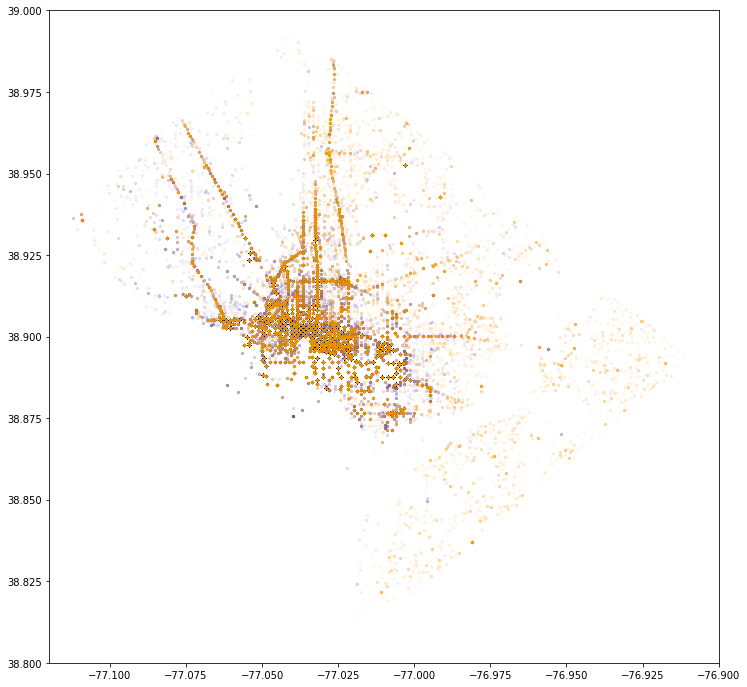

In [49]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==1].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].PICKUP_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.scatter(df.loc[df.tipping==0].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].PICKUP_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

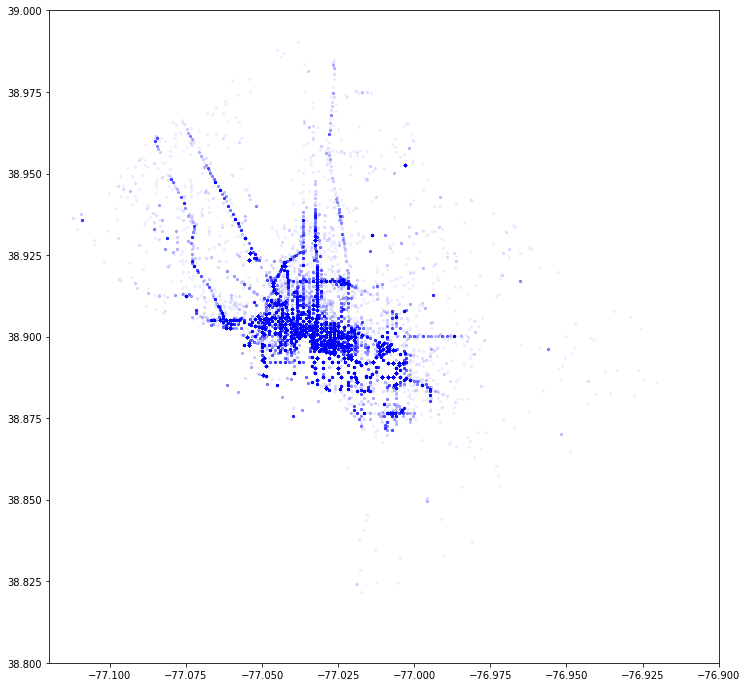

In [50]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==1].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].PICKUP_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

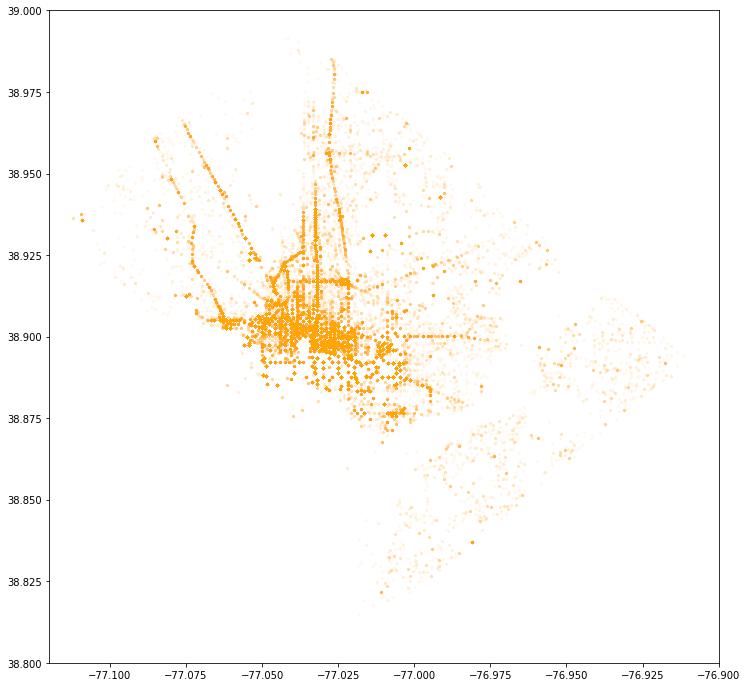

In [51]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==0].PICKUP_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].PICKUP_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

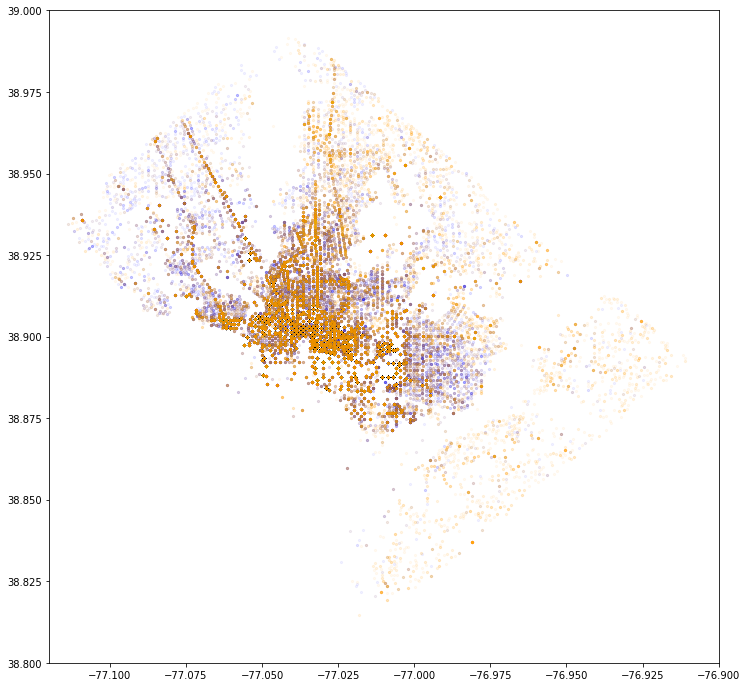

In [52]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==1].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].DROPOFF_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.scatter(df.loc[df.tipping==0].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].DROPOFF_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

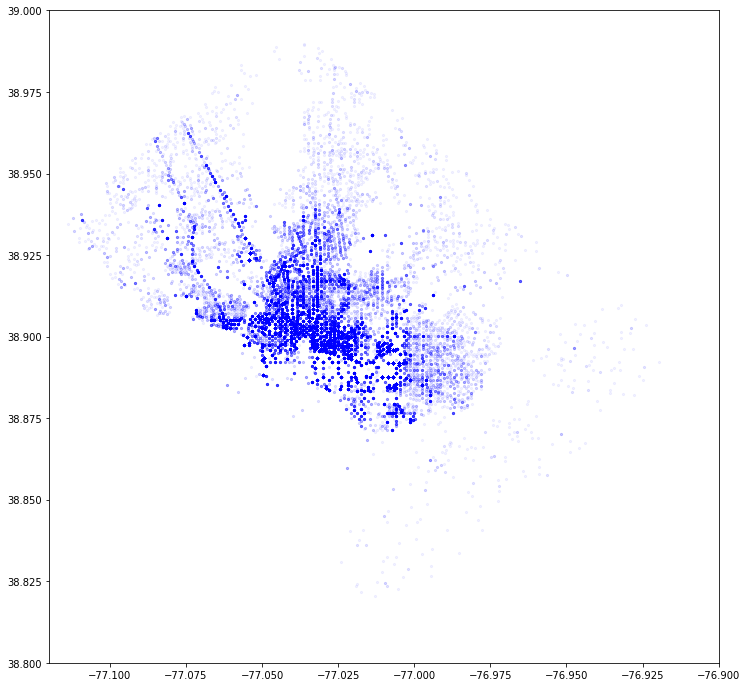

In [53]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==1].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==1].DROPOFF_BLOCK_LATITUDE, 
            alpha=0.05, 
            s=5,
            c="blue")
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

(38.8, 39.0)

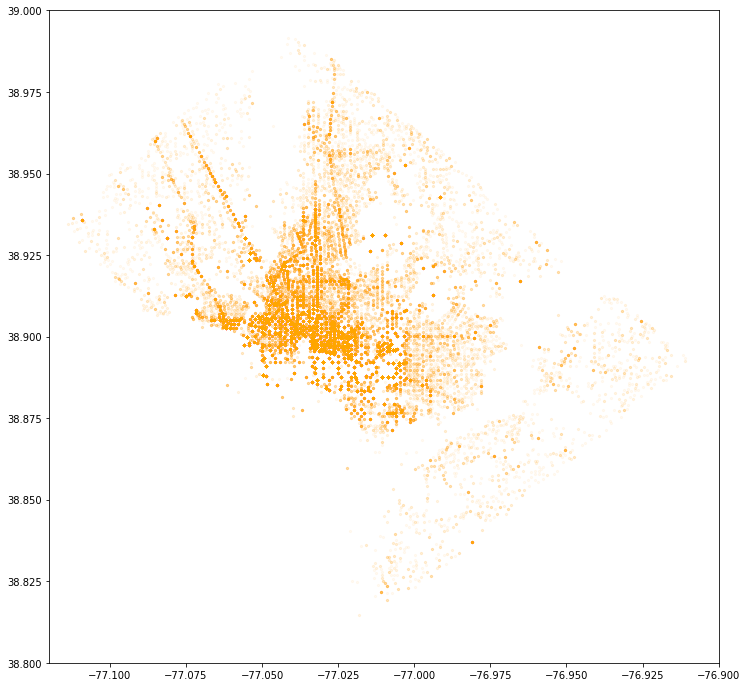

In [54]:
plt.figure(figsize=(12,12))
plt.scatter(df.loc[df.tipping==0].DROPOFF_BLOCK_LONGITUDE,
            df.loc[df.tipping==0].DROPOFF_BLOCK_LATITUDE,
            alpha=0.05,
            s=5,
            c="orange" )
plt.xlim(-77.12, -76.90)
plt.ylim(38.80, 39.00)

In [57]:
df["distance_capitol"] = np.sqrt((df.DROPOFF_BLOCK_LATITUDE-38.8899)**2
                                 +(df.DROPOFF_BLOCK_LONGITUDE+77.0091)**2)

In [8]:
df.TRIPTYPE.value_counts()

PSP             199386
DDS               1353
TRANSPORT-DC      1353
Name: TRIPTYPE, dtype: int64

In [9]:
df.groupby(["TRIPTYPE", "PROVIDER"]).tipping.describe()

count      mean       std  min  25%  50%  \
TRIPTYPE     PROVIDER                                                       
DDS          DCVIP Cab            12.0  0.833333  0.389249  0.0  1.0  1.0   
             United Ventures    1341.0  0.813572  0.389597  0.0  1.0  1.0   
PSP          CMT               45074.0  0.534499  0.498814  0.0  0.0  1.0   
             DCVIP Cab         26102.0  0.721669  0.448186  0.0  0.0  1.0   
             Hitch             28738.0  0.000418  0.020431  0.0  0.0  0.0   
             My Taxi Control    2140.0  0.433645  0.495693  0.0  0.0  0.0   
             Transco, Inc.     25525.0  0.442782  0.496725  0.0  0.0  0.0   
             United Ventures   29009.0  0.539005  0.498485  0.0  0.0  1.0   
             Verifone          26695.0  0.509609  0.499917  0.0  0.0  1.0   
             Yellow Cab of DC  16103.0  0.411600  0.492139  0.0  0.0  0.0   
TRANSPORT-DC Yellow Cab of DC   1353.0  0.001478  0.038433  0.0  0.0  0.0   

                               75%  max  
TRIPTYPE     PROVIDER                    
DDS          DCVIP Cab         1.0  1.0  
             United Ventures   1.0  1.0  
PSP          CMT               1.0  1.0  
             DCVIP Cab         1.0  1.0  
             Hitch             0.0  1.0  
             My Taxi Control   1.0  1.0  
             Transco, Inc.     1.0  1.0  
             United Ventures   1.0  1.0  
             Verifone          1.0  1.0  
             Yellow Cab of DC  1.0  1.0  
TRANSPORT-DC Yellow Cab of DC  0.0  1.0

In [10]:
df["tip_ratio"] = df.TIP / df.METERFARE
df.groupby(["TRIPTYPE", "PROVIDER"]).tip_ratio.describe()

count      mean       std  min       25%  \
TRIPTYPE     PROVIDER                                                       
DDS          DCVIP Cab            12.0  0.216145  0.202886  0.0  0.053765   
             United Ventures    1341.0  0.206747  0.130892  0.0  0.154083   
PSP          CMT               45074.0  0.135858  0.152259  0.0  0.000000   
             DCVIP Cab         26102.0  0.278980  0.459023  0.0  0.000000   
             Hitch             28738.0  0.000097  0.004973  0.0  0.000000   
             My Taxi Control    2140.0  0.101662  0.130620  0.0  0.000000   
             Transco, Inc.     25525.0  0.108911  0.148905  0.0  0.000000   
             United Ventures   29009.0  0.134053  0.151058  0.0  0.000000   
             Verifone          26695.0  0.127412  0.147267  0.0  0.000000   
             Yellow Cab of DC  16103.0  0.105184  0.147371  0.0  0.000000   
TRANSPORT-DC Yellow Cab of DC   1353.0  0.000251  0.007043  0.0  0.000000   

                                    50%       75%        max  
TRIPTYPE     PROVIDER                                         
DDS          DCVIP Cab         0.206242  0.281736   0.615385  
             United Ventures   0.229986  0.260498   1.540832  
PSP          CMT               0.125605  0.238663   5.206654  
             DCVIP Cab         0.224215  0.336323  28.230769  
             Hitch             0.000000  0.000000   0.382653  
             My Taxi Control   0.000000  0.204344   0.841043  
             Transco, Inc.     0.000000  0.212475   6.538462  
             United Ventures   0.127551  0.231214   4.106776  
             Verifone          0.105708  0.227578   3.557692  
             Yellow Cab of DC  0.000000  0.205550   2.469136  
TRANSPORT-DC Yellow Cab of DC  0.000000  0.000000   0.239044

In [11]:
df.sort_values(by="TOTALAMOUNT", ascending=False).head()

,TRIPTYPE,PROVIDER,METERFARE,TIP,SURCHARGE,EXTRAS,TOLLS,TOTALAMOUNT,PAYMENTTYPE,PAYMENTCARDPROVIDER,...,pickup_quadrant,dropoff_quadrant,tipping,pickup_datetime,dropoff_datetime,pickup_date,pickup_hour,dropoff_date,dropoff_hour,tip_ratio
125690,PSP,United Ventures,629.38,0.00,0.25,0.00,0.0,629.63,Cash,Cash,...,NaN,NaN,0,2017-07-27 17:00:00+00:00,2017-07-27 18:00:00+00:00,2017-07-27,17,2017-07-27,18,0.000000
224035,PSP,DCVIP Cab,15.40,300.00,0.25,1.00,0.0,316.65,CreditCard,VisaCredit,...,NW,SW,1,2017-07-26 17:00:00+00:00,2017-07-26 17:00:00+00:00,2017-07-26,17,2017-07-26,17,19.480519
95599,PSP,United Ventures,223.84,48.02,0.25,1.00,15.0,288.11,CreditCard,VisaCredit,...,NW,NaN,1,2017-07-24 08:00:00+00:00,2017-07-24 11:00:00+00:00,2017-07-24,8,2017-07-24,11,0.214528
22649,PSP,DCVIP Cab,192.52,40.00,0.25,3.00,0.0,235.77,CreditCard,MasterCardCredit,...,NaN,NaN,1,2017-07-23 00:00:00+00:00,2017-07-23 01:00:00+00:00,2017-07-23,0,2017-07-23,1,0.207771
202746,PSP,Yellow Cab of DC,145.81,88.00,0.25,0.25,0.0,234.06,Cash,Cash,...,NaN,NW,1,2017-07-24 14:00:00+00:00,2017-07-24 14:00:00+00:00,2017-07-24,14,2017-07-24,14,0.603525


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202092 entries, 0 to 228610
Data columns (total 37 columns):
TRIPTYPE                   202092 non-null object
PROVIDER                   202092 non-null object
METERFARE                  202092 non-null float64
TIP                        202092 non-null float64
SURCHARGE                  202092 non-null float64
EXTRAS                     202092 non-null float64
TOLLS                      202092 non-null float64
TOTALAMOUNT                202092 non-null float64
PAYMENTTYPE                202092 non-null object
PAYMENTCARDPROVIDER        201962 non-null object
PICKUPCITY                 158755 non-null object
PICKUPSTATE                163857 non-null object
PICKUPZIP                  170675 non-null object
DROPOFFCITY                147909 non-null object
DROPOFFSTATE               163088 non-null object
DROPOFFZIP                 170438 non-null object
TRIPMILEAGE                202092 non-null float64
TRIPTIME                   20209

In [13]:
df.PICKUPSTATE.value_counts()

District of Columbia    150869
Virginia                 10789
Nebraska                  1274
Maryland                   895
Montana                     17
Connecticut                 10
Delaware                     2
Indiana                      1
Name: PICKUPSTATE, dtype: int64

In [14]:
df.pickup_date.min()

datetime.date(2017, 7, 23)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


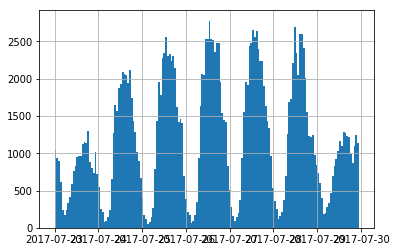

In [15]:
df.pickup_datetime.hist(bins=168)

In [16]:
formula = "TOTALAMOUNT ~ TRIPMILEAGE + TRIPTIME"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TOTALAMOUNT   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 5.302e+04
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:50:01   Log-Likelihood:            -5.5876e+05
No. Observations:              202092   AIC:                         1.118e+06
Df Residuals:                  202089   BIC:                         1.118e+06
Df Model:                           2                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7857      0.037    127.942      0.000       4.712       4.859
TRIPMILEAGE     1.7777      0.016    109.583      0.000       1.746       1.809
TRIPTIME        0.2929      0.005     53.709      0.000       0.282       0.304
==============================================================================
Omnibus:                   446861.554   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      61659210161.938
Skew:                          19.136   Prob(JB):                         0.00
Kurtosis:                    2708.743   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [17]:
formula = "METERFARE ~ TRIPMILEAGE"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              METERFARE   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                 3.427e+04
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:50:01   Log-Likelihood:            -5.4303e+05
No. Observations:              202092   AIC:                         1.086e+06
Df Residuals:                  202090   BIC:                         1.086e+06
Df Model:                           1                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.8945      0.030    193.593      0.000       5.835       5.954
TRIPMILEAGE     1.9811      0.011    185.126      0.000       1.960       2.002
==============================================================================
Omnibus:                   439813.182   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      86905178934.813
Skew:                          18.250   Prob(JB):                         0.00
Kurtosis:                    3215.372   Cond. No.                         6.79
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [18]:
formula = "TRIPMILEAGE ~ TRIPTIME"
model = smf.ols(formula, df).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            TRIPMILEAGE   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                 1.239e+04
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:50:02   Log-Likelihood:            -5.2346e+05
No. Observations:              202092   AIC:                         1.047e+06
Df Residuals:                  202090   BIC:                         1.047e+06
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9310      0.032    -28.815      0.000      -0.994      -0.868
TRIPTIME       0.3018      0.003    111.323      0.000       0.296       0.307
==============================================================================
Omnibus:                   193255.338   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26594274.310
Skew:                           4.265   Prob(JB):                         0.00
Kurtosis:                      58.548   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [19]:
formula = "TIP ~ METERFARE"
model = smf.ols(formula, df.loc[df.tipping==1]).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TIP   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     7232.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:50:02   Log-Likelihood:            -1.9463e+05
No. Observations:               92142   AIC:                         3.893e+05
Df Residuals:                   92140   BIC:                         3.893e+05
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9773      0.022     44.228      0.000       0.934       1.021
METERFARE      0.1625      0.002     85.040      0.000       0.159       0.166
==============================================================================
Omnibus:                   299534.614   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     160804839457.021
Skew:                          54.384   Prob(JB):                         0.00
Kurtosis:                    6473.905   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

(0, 50)

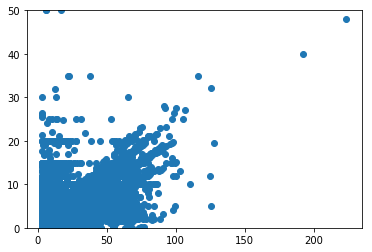

In [35]:
plt.scatter(df.loc[df.tipping==1].METERFARE, df.loc[df.tipping==1].TIP)
plt.ylim(0,50)

In [36]:
formula = "TIP ~ METERFARE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour)"
model = smf.ols(formula, df.loc[df.tipping==1]).fit(cov_type="HC1")
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TIP   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     469.2
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:05:07   Log-Likelihood:            -1.9387e+05
No. Observations:               92142   AIC:                         3.878e+05
Df Residuals:                   92101   BIC:                         3.882e+05
Df Model:                          40                                         
Covariance Type:                  HC1                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        1.3692      0.076     17.911      0.000       1.219       1.519
C(PROVIDER)[T.DCVIP Cab]                         0.3192      0.042      7.636      0.000       0.237       0.401
C(PROVIDER)[T.Hitch]                            -0.6363      0.206     -3.087      0.002      -1.040      -0.232
C(PROVIDER)[T.My Taxi Control]                  -0.4719      0.061     -7.766      0.000      -0.591      -0.353
C(PROVIDER)[T.Transco, Inc.]                    -0.0300      0.013     -2.258      0.024      -0.056      -0.004
C(PROVIDER)[T.United Ventures]                  -0.0201      0.013     -1.507      0.132      -0.046       0.006
C(PROVIDER)[T.Verifone]                         -0.0330      0.012     -2.700      0.007      -0.057      -0.009
C(PROVIDER)[T.Yellow Cab of DC]                 -0.2784      0.057     -4.925      0.000      -0.389      -0.168
AIRPORT[T.True]                                  0.4277      0.030     14.377      0.000       0.369       0.486
C(PAYMENTTYPE)[T.CreditCard]                    -0.2923      0.053     -5.489      0.000      -0.397      -0.188
C(PAYMENTTYPE)[T.Voucher]                       -0.7113      0.087     -8.157      0.000      -0.882      -0.540
C(pickup_date)[T.datetime.date(2017, 7, 24)]    -0.0381      0.028     -1.363      0.173      -0.093       0.017
C(pickup_date)[T.datetime.date(2017, 7, 25)]    -0.0546      0.025     -2.148      0.032      -0.104      -0.005
C(pickup_date)[T.datetime.date(2017, 7, 26)]    -0.0191      0.031     -0.609      0.543      -0.081       0.042
C(pickup_date)[T.datetime.date(2017, 7, 27)]    -0.0484      0.026     -1.832      0.067      -0.100       0.003
C(pickup_date)[T.datetime.date(2017, 7, 28)]    -0.0765      0.026     -2.960      0.003      -0.127      -0.026
C(pickup_date)[T.datetime.date(2017, 7, 29)]     0.0152      0.039      0.393      0.695      -0.061       0.091
C(pickup_hour)[T.1]                              0.0327      0.139      0.235      0.814      -0.240       0.305
C(pickup_hour)[T.2]                              0.0223      0.139      0.161      0.872      -0.250       0.295
C(pickup_hour)[T.3]                             -0.1882      0.088     -2.130      0.033      -0.361      -0.015
C(pickup_hour)[T.4]                             -0.2771      0.109     -2.533      0.011      -0.491      -0.063
C(pickup_hour)[T.5]                             -0.2597      0.108     -2.412      0.016      -0.471      -0.049
C(pickup_hour)[T.6]                             -0.2105      0.073     -2.885      0.004      -0.354      -0.067
C(pickup_hour)[T.7]                             -0.1620      0.059     -2.738      0.006      -0.278      -0.046
C(pickup_hour)[T.8]             

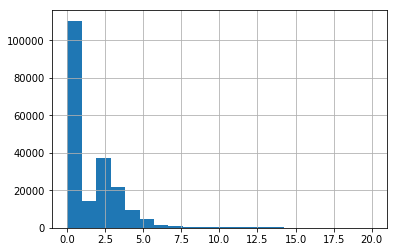

In [21]:
df.loc[df.TIP<20].TIP.hist(bins=21)

In [22]:
formula = "tipping ~ METERFARE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE)"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.219740
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               202092
Model:                          Logit   Df Residuals:                   202049
Method:                           MLE   Df Model:                           42
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                  0.6812
Time:                        13:50:13   Log-Likelihood:                -44408.
converged:                       True   LL-Null:                   -1.3929e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -4.0365      0.173    -23.327      0.000      -4.376      -3.697
C(PROVIDER)[T.DCVIP Cab]                         4.5059      0.050     89.930      0.000       4.408       4.604
C(PROVIDER)[T.Hitch]                            -9.6696      0.291    -33.190      0.000     -10.241      -9.099
C(PROVIDER)[T.My Taxi Control]                   3.9959      0.061     65.400      0.000       3.876       4.116
C(PROVIDER)[T.Transco, Inc.]                    -0.7659      0.034    -22.401      0.000      -0.833      -0.699
C(PROVIDER)[T.United Ventures]                   0.1617      0.034      4.740      0.000       0.095       0.228
C(PROVIDER)[T.Verifone]                         -0.6316      0.033    -18.868      0.000      -0.697      -0.566
C(PROVIDER)[T.Yellow Cab of DC]                  4.0003      0.045     88.533      0.000       3.912       4.089
AIRPORT[T.True]                                  0.5312      0.031     17.061      0.000       0.470       0.592
C(PAYMENTTYPE)[T.CreditCard]                     7.1416      0.049    145.782      0.000       7.046       7.238
C(PAYMENTTYPE)[T.Voucher]                        6.4749      0.245     26.403      0.000       5.994       6.956
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3791      0.036     10.660      0.000       0.309       0.449
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.5112      0.035     14.673      0.000       0.443       0.580
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5702      0.034     16.565      0.000       0.503       0.638
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5565      0.034     16.231      0.000       0.489       0.624
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.3136      0.035      9.037      0.000       0.246       0.382
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0423      0.038     -1.116      0.265      -0.117       0.032
C(pickup_hour)[T.1]                             -0.1721      0.094     -1.830      0.067      -0.356       0.012
C(pickup_hour)[T.2]                             -0.1692      0.096     -1.755      0.079      -0.358       0.020
C(pickup_hour)[T.3]                             -0.3087      0.116     -2.664      0.008      -0.536      -0.082
C(pickup_hour)[T.4]                             -0.6656      0.126     -5.290      0.000      -0.912      -0.419
C(pickup_hour)[T.5]                             -0.5154      0.117     -4.397      0.000      -0.745      -0.286
C(pickup_hour)[T.6]                             -0.4820      0.094     -5.117      0.000      -0.667      -0.297
C(pickup_hour)[T.7]                             -0.3404      0.077     -4.432      0.000      -0.491      -0.190
C(pickup_hour)[T.8]                             -0.1620      0.071     -2.292      0.022      -0.301      -0.023
C(pickup_hour)[T.9]                             -0.0046      0.068     -0.068

In [58]:
formula = "tipping ~ METERFARE + C(PROVIDER) + AIRPORT + C(PAYMENTTYPE) + C(pickup_date) + C(pickup_hour) + C(TRIPTYPE) + C(dropoff_quadrant) * distance_capitol"
model = smf.logit(formula, df).fit(cov_type="HC1")
model.summary()

Optimization terminated successfully.
         Current function value: 0.208707
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                tipping   No. Observations:               159145
Model:                          Logit   Df Residuals:                   159095
Method:                           MLE   Df Model:                           49
Date:                Mon, 29 Jul 2019   Pseudo R-squ.:                  0.6968
Time:                        14:47:49   Log-Likelihood:                -33215.
converged:                       True   LL-Null:                   -1.0956e+05
                                        LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -3.5449      0.198    -17.909      0.000      -3.933      -3.157
C(PROVIDER)[T.DCVIP Cab]                         4.6630      0.058     80.032      0.000       4.549       4.777
C(PROVIDER)[T.Hitch]                            -9.9248      0.357    -27.827      0.000     -10.624      -9.226
C(PROVIDER)[T.My Taxi Control]                   4.0563      0.069     58.620      0.000       3.921       4.192
C(PROVIDER)[T.Transco, Inc.]                    -0.7974      0.040    -20.045      0.000      -0.875      -0.719
C(PROVIDER)[T.United Ventures]                   0.1413      0.039      3.607      0.000       0.065       0.218
C(PROVIDER)[T.Verifone]                         -0.6819      0.039    -17.301      0.000      -0.759      -0.605
C(PROVIDER)[T.Yellow Cab of DC]                  4.1328      0.053     78.431      0.000       4.030       4.236
AIRPORT[T.True]                                  0.3467      0.049      7.057      0.000       0.250       0.443
C(PAYMENTTYPE)[T.CreditCard]                     7.2888      0.057    127.305      0.000       7.177       7.401
C(PAYMENTTYPE)[T.Voucher]                        6.6697      0.279     23.923      0.000       6.123       7.216
C(pickup_date)[T.datetime.date(2017, 7, 24)]     0.3635      0.042      8.657      0.000       0.281       0.446
C(pickup_date)[T.datetime.date(2017, 7, 25)]     0.4714      0.041     11.384      0.000       0.390       0.553
C(pickup_date)[T.datetime.date(2017, 7, 26)]     0.5127      0.041     12.545      0.000       0.433       0.593
C(pickup_date)[T.datetime.date(2017, 7, 27)]     0.5123      0.041     12.557      0.000       0.432       0.592
C(pickup_date)[T.datetime.date(2017, 7, 28)]     0.2867      0.041      6.960      0.000       0.206       0.367
C(pickup_date)[T.datetime.date(2017, 7, 29)]    -0.0897      0.045     -2.001      0.045      -0.178      -0.002
C(pickup_hour)[T.1]                             -0.1623      0.109     -1.482      0.138      -0.377       0.052
C(pickup_hour)[T.2]                             -0.1183      0.115     -1.033      0.302      -0.343       0.106
C(pickup_hour)[T.3]                             -0.1947      0.156     -1.250      0.211      -0.500       0.111
C(pickup_hour)[T.4]                             -0.9716      0.208     -4.664      0.000      -1.380      -0.563
C(pickup_hour)[T.5]                             -1.2150      0.206     -5.887      0.000      -1.619      -0.810
C(pickup_hour)[T.6]                             -0.8716      0.126     -6.938      0.000      -1.118      -0.625
C(pickup_hour)[T.7]                             -0.4945      0.090     -5.488      0.000      -0.671      -0.318
C(pickup_hour)[T.8]                             -0.2134      0.082     -2.591      0.010      -0.375      -0.052
C(pickup_hour)[T.9]                             -0.0904      0.079     -1.142

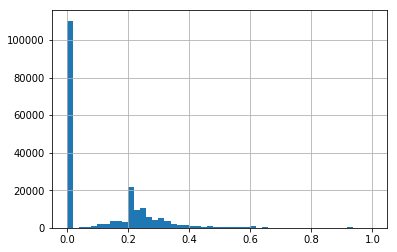

In [23]:
df.loc[df.tip_ratio<1].tip_ratio.hist(bins=50)

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


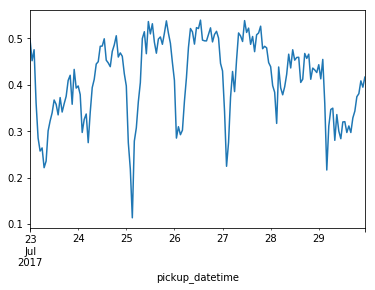

In [24]:
df.groupby("pickup_datetime").tipping.mean().plot()

In [25]:
ts_tipping = df.groupby("pickup_datetime").tipping.mean()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


<Figure size 432x288 with 0 Axes>

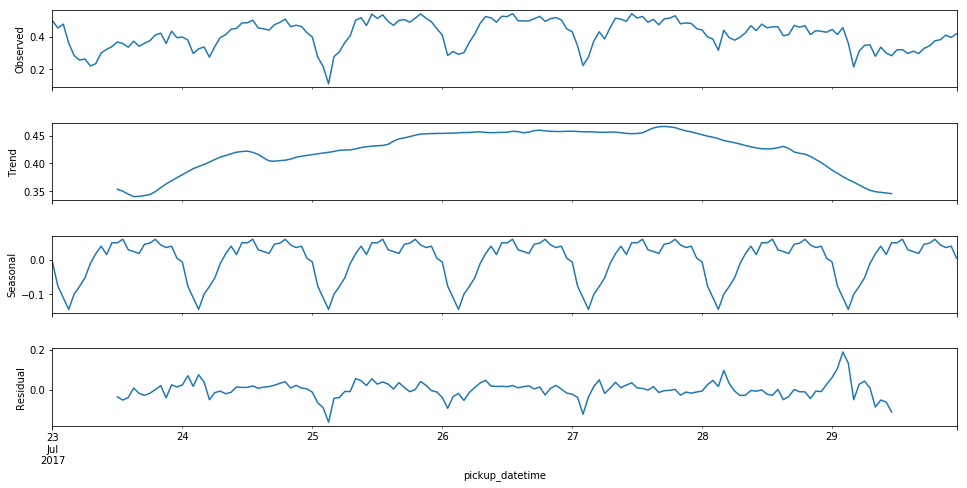

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_tipping, freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [27]:
from statsmodels.tsa.stattools import adfuller
pd.Series(adfuller(ts_tipping, autolag='AIC')[0:4], 
          index=['Test Statistic',
                 'p-value',
                 '#Lags Used',
                 'Number of Observations Used'])


Test Statistic                  -4.825443
p-value                          0.000049
#Lags Used                       4.000000
Number of Observations Used    163.000000
dtype: float64

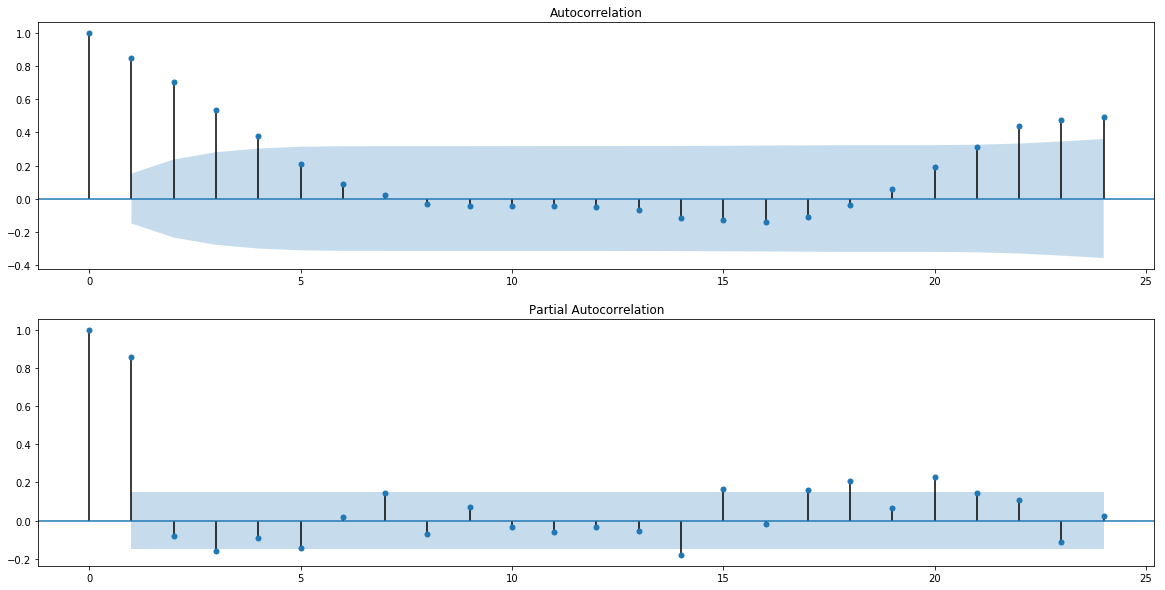

In [28]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ts_tipping, lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ts_tipping, lags=24, ax=ax[1])
plt.show()

In [29]:
resDiff = sm.tsa.arma_order_select_ic(ts_tipping, max_ar=6, max_ma=3, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency informat

ARMA(p,q) = (4, 2) is the best.


In [59]:
sarima = sm.tsa.statespace.SARIMAX(ts_tipping,
                                  order=(4,1,2),
                                  freq='H',
                                  seasonal_order=(1,1,1,24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit()
sarima.summary()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            tipping   No. Observations:                  168
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 24)   Log Likelihood                 134.356
Date:                            Mon, 29 Jul 2019   AIC                           -250.713
Time:                                    15:09:42   BIC                           -226.008
Sample:                                07-23-2017   HQIC                          -240.685
                                     - 07-29-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3766      0.139    -17.057      0.000      -2.650      -2.103
ar.L2         -2.9129      0.260    -11.193      0.000      -3.423      -2.403
ar.L3         -2.5595      0.251    -10.202      0.000      -3.051      -2.068
ar.L4         -1.0751      0.117     -9.185      0.000      -1.305      -0.846
ma.L1          4.1252      1.324      3.116      0.002       1.530       6.720
ma.L2          3.1509      1.327      2.374      0.018       0.549       5.752
ar.S.L24       0.4163      0.090      4.628      0.000       0.240       0.593
ma.S.L24      -0.2204      0.147     -1.503      0.133      -0.508       0.067
sigma2         0.0005      0.000      1.255      0.209      -0.000       0.001
===================================================================================
Ljung-Box (Q):                       63.56   Jarque-Bera (JB):                 3.05
Prob(Q):                              0.01   Prob(JB):                         0.22
Heteroskedasticity (H):               0.93   Skew:                            -0.15
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

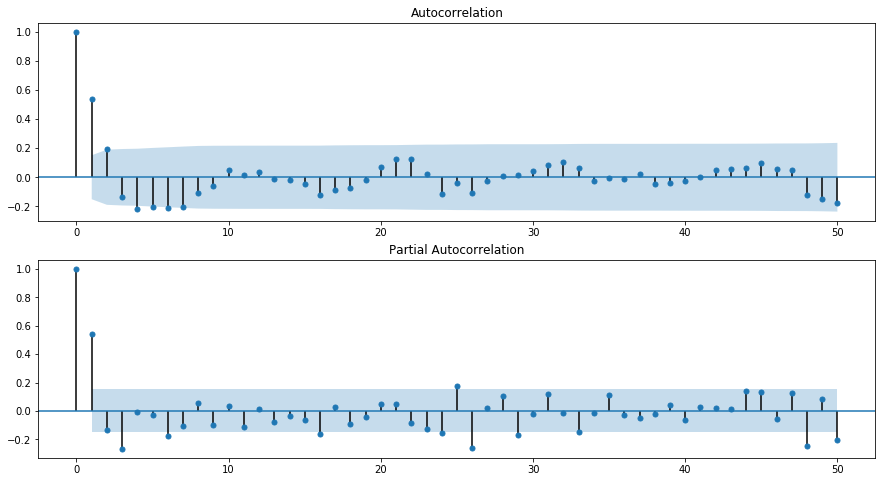

In [60]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [61]:
pred = sarima.predict()

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


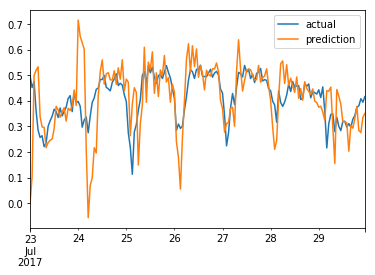

In [62]:
pd.DataFrame({'actual':ts_tipping,'prediction':pred}).plot();plt.show()